## Classifier

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim

import timm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm


### Dataset definition

In [2]:
class CardsData(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    # ImageFolder is a dataset class which loads image data from a folder and 
    # image is classified based on the name of subfolder 

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        return self.data[i]
    
    @property
    def classes(self):
        return self.data.classes



### Defining Transformation for image

In [3]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

### Creating training, testing, and validation dataset using CardsData class a subclass of pytorch Dataset

In [4]:
train_dataset = CardsData('../data/train/', transform)
test_dataset = CardsData('../data/test/', transform)
val_dataset = CardsData('../data/valid/', transform)

In [5]:
import os
print(os.getcwd())


c:\Users\shrey\Desktop\projects\playing card classifier\model


In [6]:
target_to_class ={v:k for k,v in ImageFolder('../data/train').class_to_idx.items()}
target_to_class


{0: 'ace of clubs',
 1: 'ace of diamonds',
 2: 'ace of hearts',
 3: 'ace of spades',
 4: 'eight of clubs',
 5: 'eight of diamonds',
 6: 'eight of hearts',
 7: 'eight of spades',
 8: 'five of clubs',
 9: 'five of diamonds',
 10: 'five of hearts',
 11: 'five of spades',
 12: 'four of clubs',
 13: 'four of diamonds',
 14: 'four of hearts',
 15: 'four of spades',
 16: 'jack of clubs',
 17: 'jack of diamonds',
 18: 'jack of hearts',
 19: 'jack of spades',
 20: 'joker',
 21: 'king of clubs',
 22: 'king of diamonds',
 23: 'king of hearts',
 24: 'king of spades',
 25: 'nine of clubs',
 26: 'nine of diamonds',
 27: 'nine of hearts',
 28: 'nine of spades',
 29: 'queen of clubs',
 30: 'queen of diamonds',
 31: 'queen of hearts',
 32: 'queen of spades',
 33: 'seven of clubs',
 34: 'seven of diamonds',
 35: 'seven of hearts',
 36: 'seven of spades',
 37: 'six of clubs',
 38: 'six of diamonds',
 39: 'six of hearts',
 40: 'six of spades',
 41: 'ten of clubs',
 42: 'ten of diamonds',
 43: 'ten of hear

In [7]:
train_dataset[0][0].shape

torch.Size([3, 128, 128])

### Dataloader
Dataloader is used for easy looping of data, paralleization of batches and functionalities like batching, shuffling and more

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle= True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle= True)

### Model
Here we are using a 

In [9]:
class CardClassifier(nn.Module):
    def __init__(self,num_classes=53):
        super(CardClassifier,self).__init__()
        self.base_model = timm.create_model('efficientnet_b0',pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )
    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output


In [10]:
model = CardClassifier(num_classes=53)
print(str(model)[:500])

CardClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
 


### Training loop

In [11]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Simple training loop
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = CardClassifier(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 1.5684358809702295, Validation loss: 0.38766890997594255


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.5685704629418732, Validation loss: 0.2976638673049099


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.3462053049836554, Validation loss: 0.11274968001921222


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.23872809018255656, Validation loss: 0.1558135486295763


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.1608672562492122, Validation loss: 0.2501338706826264


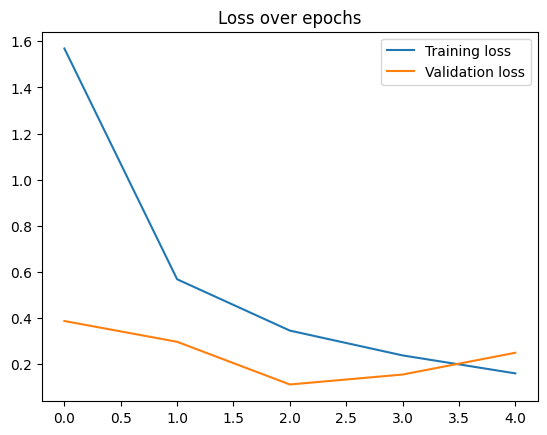

In [13]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

### Saving Model weights


In [14]:
torch.save(model.state_dict(), 'card_classifier_weights.pth')